In [1]:
import numpy as np
from tqdm import tqdm
import cv2
import glob
import matplotlib.pyplot as plt

from IPython.display import *
import pickle

from moviepy.editor import VideoFileClip
from IPython.display import HTML

!mkdir test_videos_output

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mkdir: test_videos_output: File exists


In [2]:
dist_pickle = pickle.load(open('dist.p', 'rb'))
dist = dist_pickle['dist']
mtx = dist_pickle['mtx']

def show(img):
    if len(img.shape) > 2:
        img = img[:,:,::-1]
    cv2.imwrite('test.jpg', img)
    display(Image('test.jpg'))

class Smooth:
    def __init__(self, windowsize=24):
        self.window_size = windowsize
        self.data = np.zeros((self.window_size,), dtype=np.float32)
        self.index = 0
    
    def __iadd__(self, x):
        if self.index == 0:
            self.data[:] = x
        self.data[self.index % self.window_size] = x
        self.index += 1
        return self

    def __float__(self):
        return float(self.data.mean())

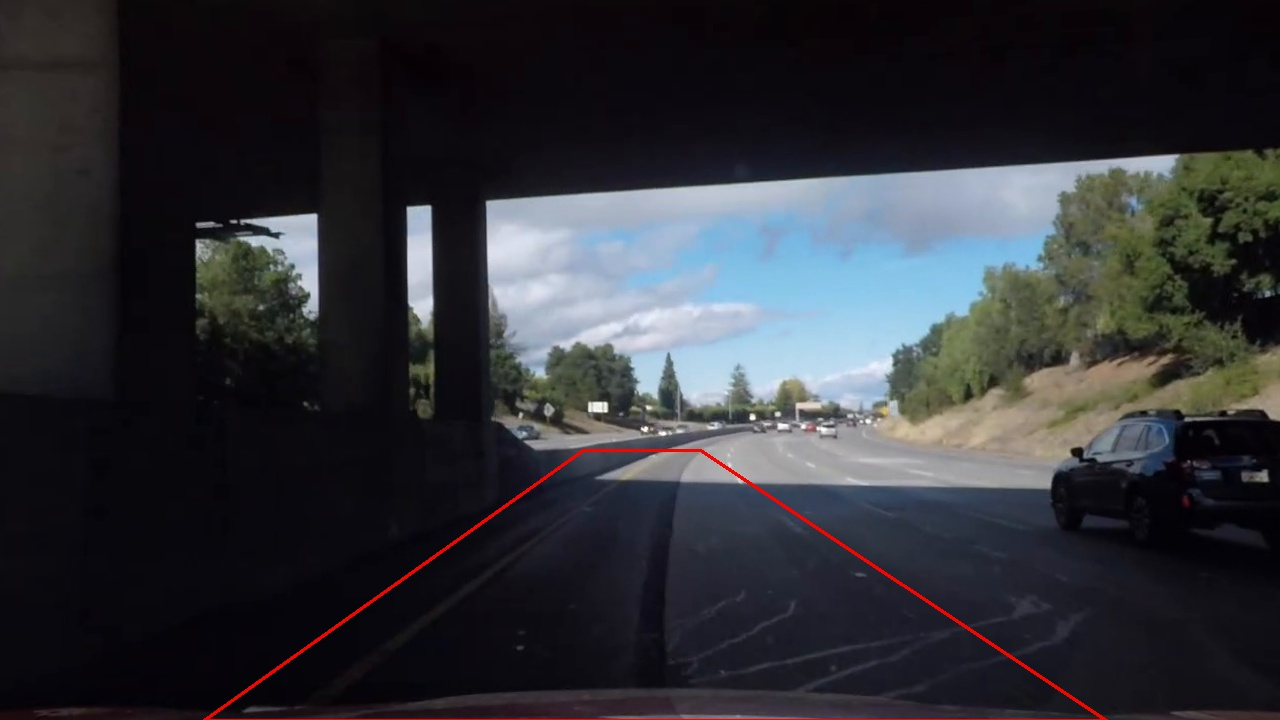

In [263]:
# image = cv2.imread('test_images/straight_lines2.jpg')
image = cv2.imread('test_images/challenge.jpg')[:,:,::-1]
# image = cv2.imread('test_images/test1.jpg')[:,:,::-1]

img_size = (image.shape[1], image.shape[0])
undist = cv2.undistort(image, mtx, dist, None, mtx)
undist_line = undist.copy()

fy = image.shape[0]/720.0
fx = image.shape[1]/1280.0

src = np.array(
    [[583*fx, 450*fy],
     [204*fx, 720*fy],
     [1106*fx, 720*fy],
     [700*fx, 450*fy]], np.float32)

dst = np.array(
    [[320*fx, 0*fy],
     [320*fx, 720*fy],
     [960*fx, 720*fy],
     [960*fx, 0*fy]], np.float32)

for (x1, y1), (x2, y2) in zip(src, src[[1, 2, 3, 0]]):
    cv2.line(undist_line, (int(x1), int(y1)), (int(x2), int(y2)), (255,0,0), 2)

show(undist_line)

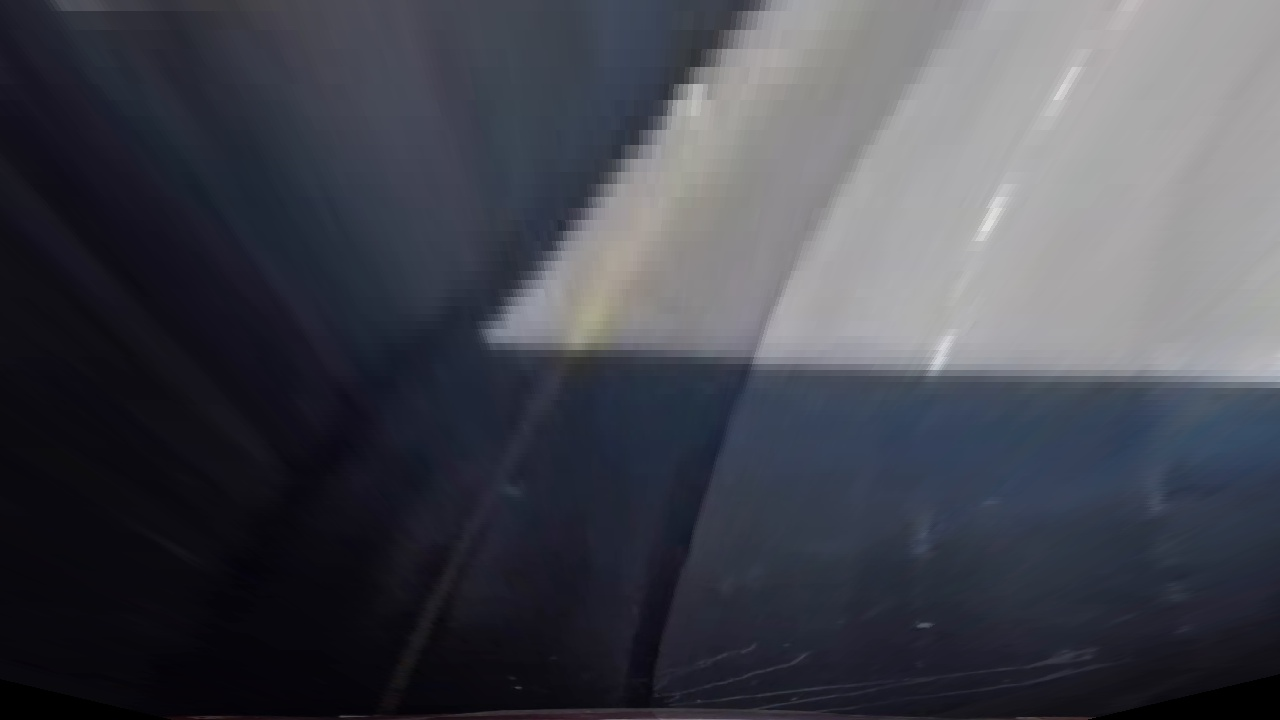

In [264]:
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_NEAREST)
show(warped)

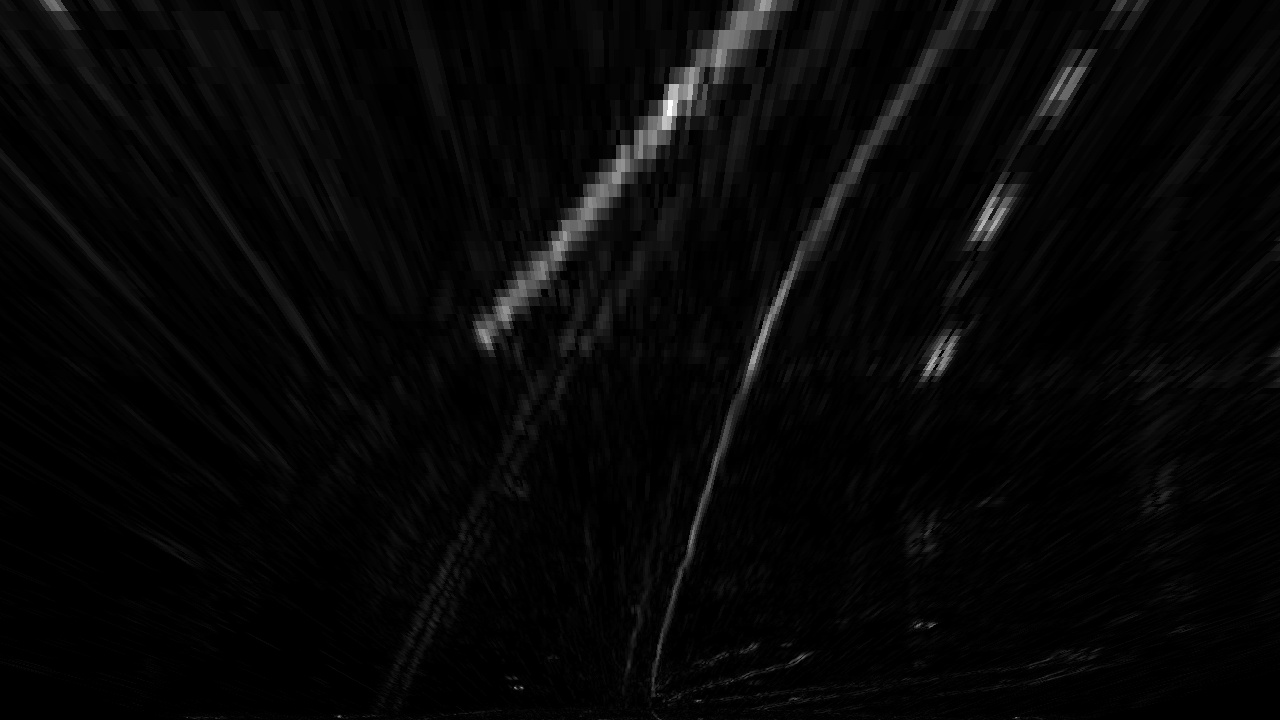

In [265]:
gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
sobelx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
abs_sobelx = np.absolute(sobelx)
warped_sobel = cv2.warpPerspective(abs_sobelx, M, img_size, flags=cv2.INTER_NEAREST)
warped_sobel = np.uint8(255.0*warped_sobel/warped_sobel.max())

show(warped_sobel)

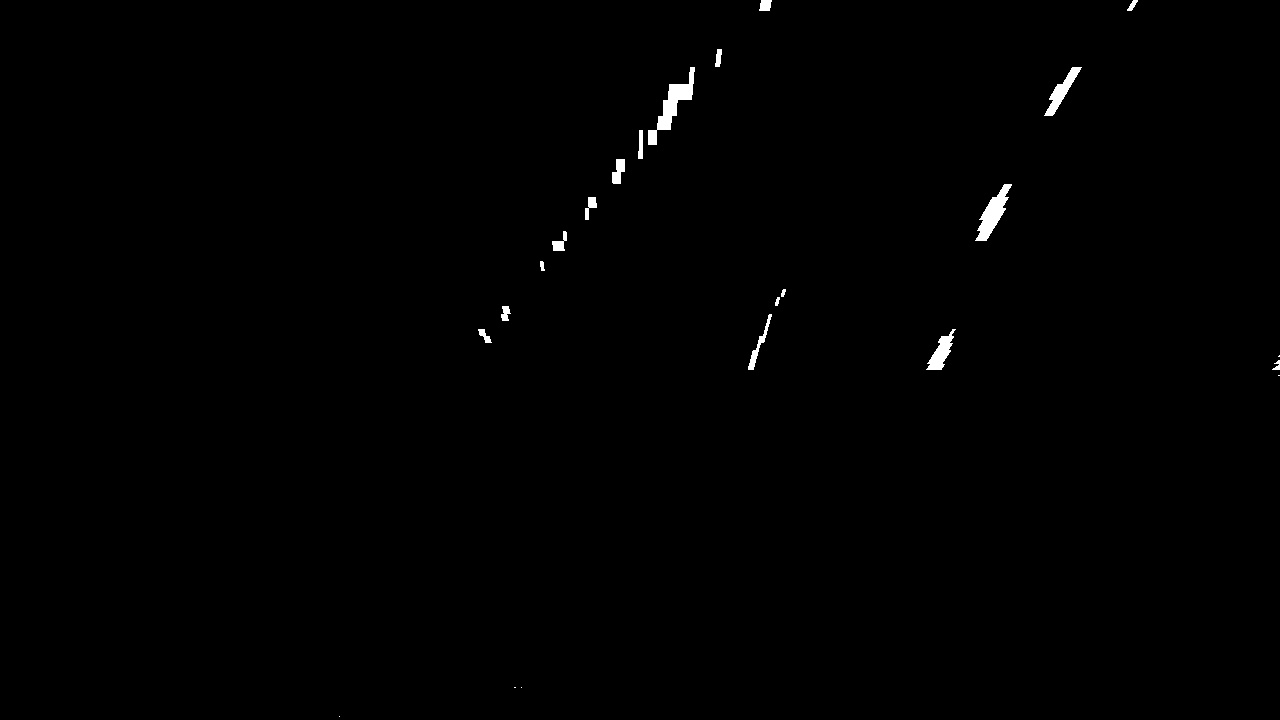

In [266]:
hsv = cv2.cvtColor(warped, cv2.COLOR_RGB2HSV)
yellow = cv2.inRange(hsv, (10, 80, 128), (25, 255, 255))
white = cv2.inRange(hsv, (0, 0, 192), (255, 32, 255))
yellow_white = cv2.bitwise_or(yellow, white)
ret, bw1 = cv2.threshold(yellow_white, 127, 255, cv2.THRESH_BINARY)
ret, bw2 = cv2.threshold(warped_sobel, 127, 255, cv2.THRESH_BINARY)
bw = cv2.bitwise_or(bw1, bw2)

show(bw)

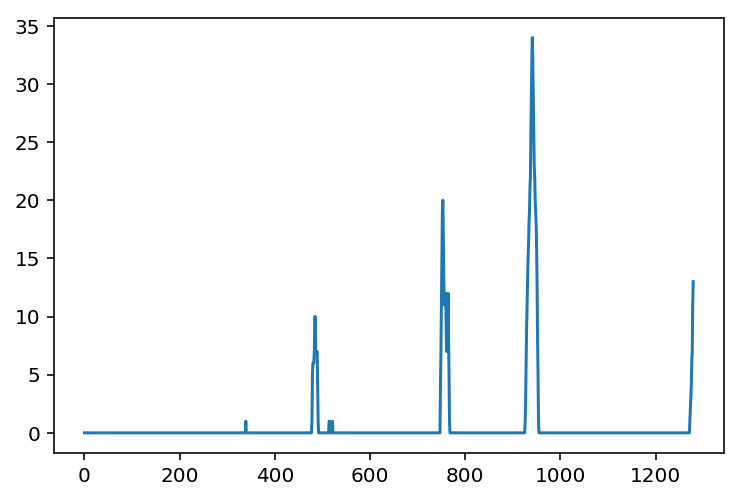

In [267]:
histogram = np.sum(bw[bw.shape[0]//2-30:,:], axis=0)/255
out_img = cv2.cvtColor(bw, cv2.COLOR_GRAY2RGB)
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

plt.plot(histogram)

In [268]:
# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(bw.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = bw.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = bw.shape[0] - (window+1)*window_height
    win_y_high = bw.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

In [269]:
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

In [270]:
# Generate x and y values for plotting
ploty = np.linspace(0, bw.shape[0]-1, bw.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

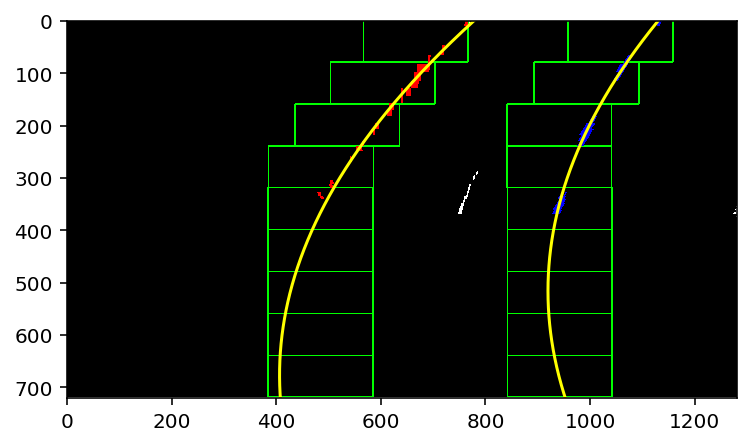

In [271]:
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [272]:
# y=Ax^2+Bx+C

print('y=%.2fx^2+%.2fx+%.2f' % (left_fit[0], left_fit[1], left_fit[2]))
print('y=%.2fx^2+%.2fx+%.2f' % (right_fit[0], right_fit[1], right_fit[2]))

y=0.00x^2+-1.10x+777.72
y=0.00x^2+-0.82x+1130.01


(720, 0)

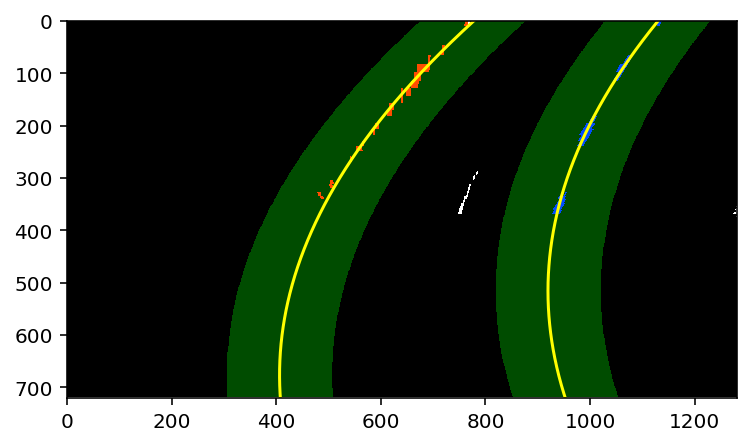

In [273]:
# Create an image to draw on and an image to show the selection window
out_img = cv2.cvtColor(bw, cv2.COLOR_GRAY2RGB)
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [274]:
left_curverad = ((1 + (2*left_fit[0]*30 + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*30 + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

1876.53608373 1268.75159734


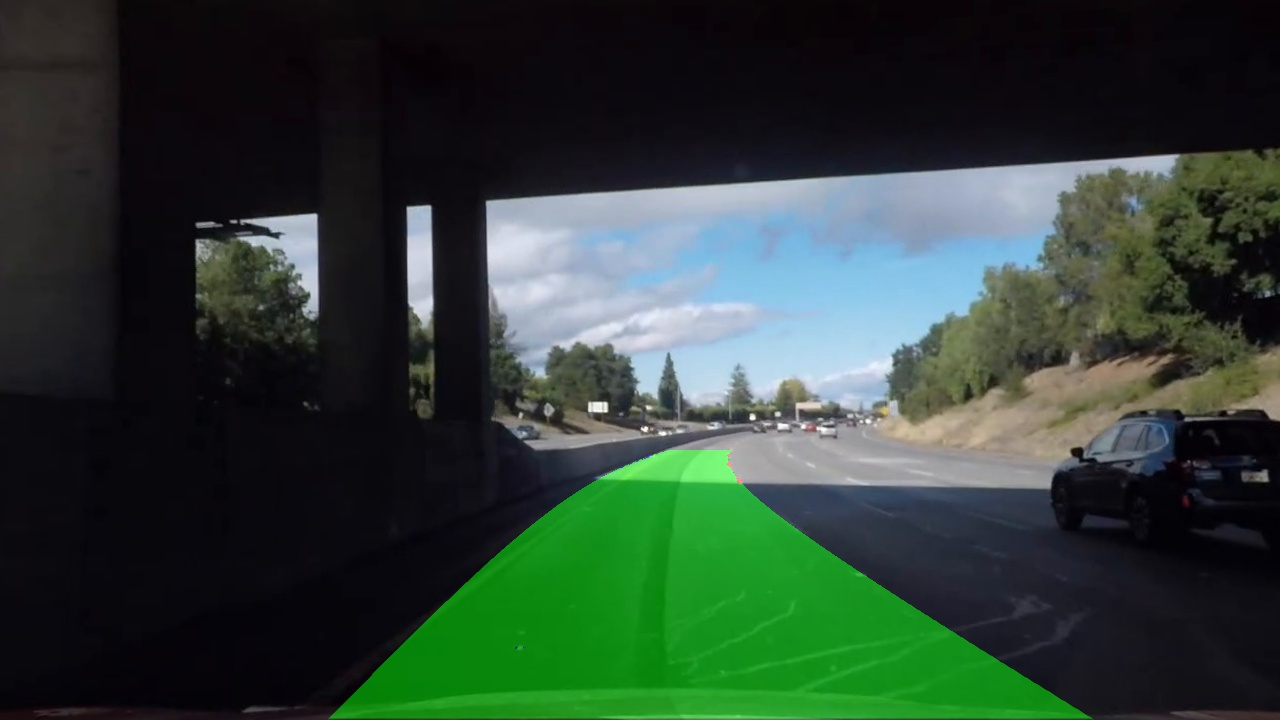

In [275]:
# Create an image to draw the lines on
color_warp = np.zeros_like(warped).astype(np.uint8)

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, pts.astype(int), (0,255, 0))

# Color in left and right line pixels
color_warp[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [0, 0, 255]
color_warp[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [255, 0, 0]

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))

# Combine the result with the original image
mask = (cv2.cvtColor(newwarp, cv2.COLOR_BGR2GRAY) > 0).astype(np.uint8)
result = cv2.addWeighted(undist, 0.7, newwarp, 0.5, 0)
result_mask = cv2.bitwise_or(result, result, mask=mask)
mask = 1 - mask
undist_mask = cv2.bitwise_or(undist, undist, mask=mask)
result = cv2.bitwise_or(undist_mask, result_mask)

show(result)